Alexander W. Criswell 9/15/25

Test notebook for the initial cupy-based implementation of pelargir-gb.

In [1]:
%load_ext autoreload
%autoreload 2

In [140]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [141]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [142]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq
import distributions as st

Okay, imports successful. We're going to try to follow the toy model notebook and reproduce the results. They won't be perfectly identical, as some of the underlying sampling routines are different, but they should generally follow.

In [4]:
test_rng = np.random.default_rng(170817)

In [11]:
test_prior = GalacticBinaryPrior(test_rng)

In [12]:
pop_theta = {'m_mu':np.array([0.6]),'m_sigma':np.array([0.15]),
             # 'd_mu':np.array([30]),'d_sigma':np.array([10]),
             'd_gamma_a':np.array([4]),'d_gamma_b':np.array([4]),
             'a_alpha':np.array([1/2])}
test_prior.condition(pop_theta)

In [13]:
samps = test_prior.sample_conditional(int(1e7))

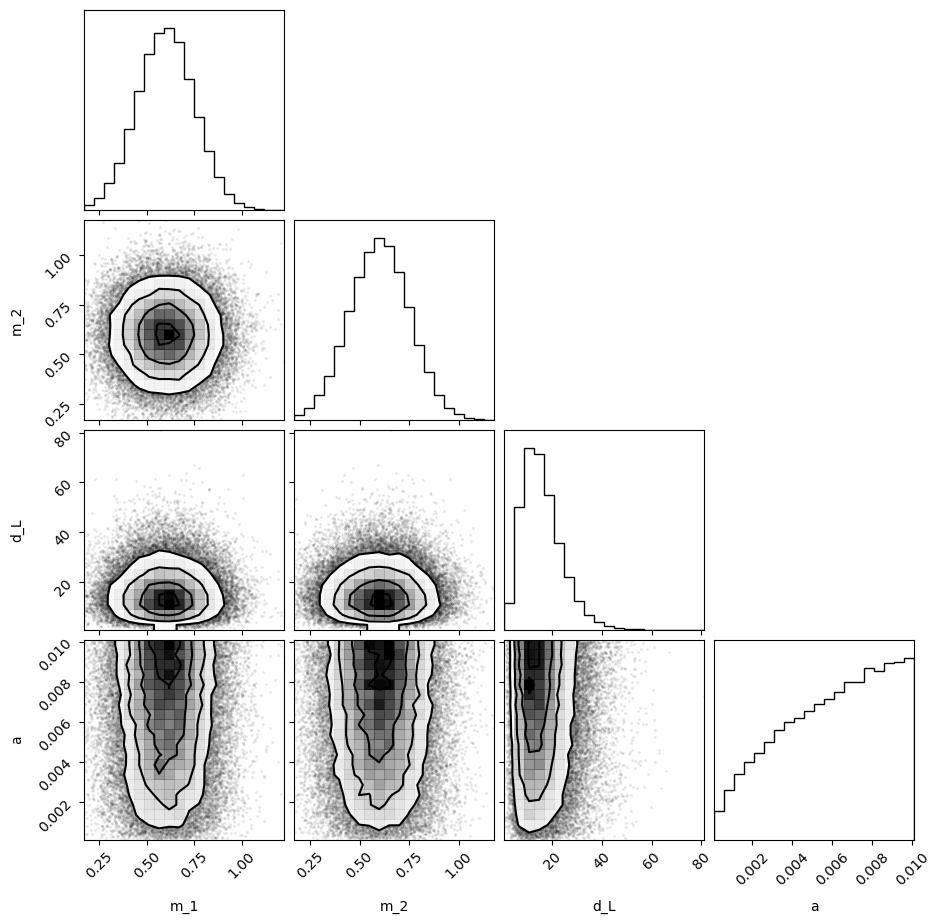

In [14]:
plt.close()
fig = corner(samps[:,::200].T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [15]:
amps, fgws = get_amp_freq(samps)

Okay, good. The conditional prior class works and allows for data generation. Now let's instantiate the hyperprior for the population-level parameters,  as well as the population model:

In [16]:
test_hprior = PopulationHyperPrior(test_rng)

In [17]:
test_hprior_samples = test_hprior.sample(size=1000)

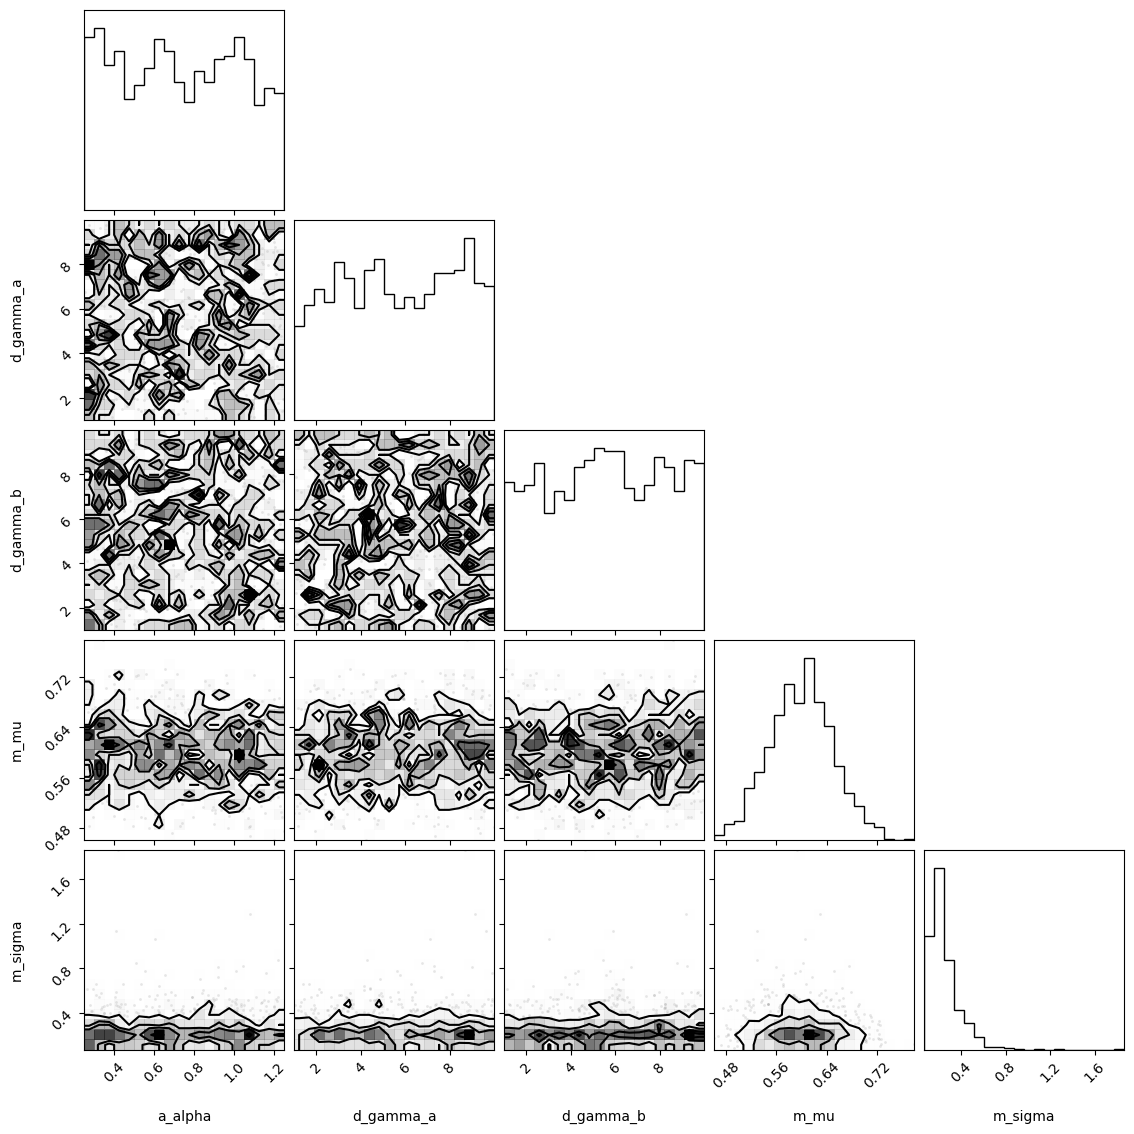

In [18]:
plt.close()
fig = corner(test_hprior_samples)

plt.show()

In [92]:
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0)

In [93]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [94]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(np.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [95]:
data_N_res

721

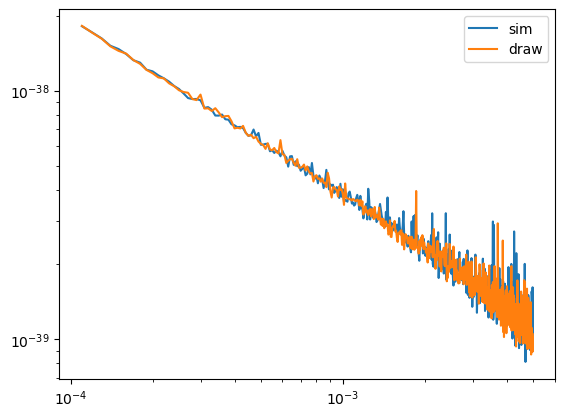

In [96]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(test_f,data_fg,label='sim')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.loglog(test_f, test_fg,label='draw')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

Good. Identical up to the Poisson realization. Now check that sampling the (hyper)parameter space creates appropriate spectral spread

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.50s/it]


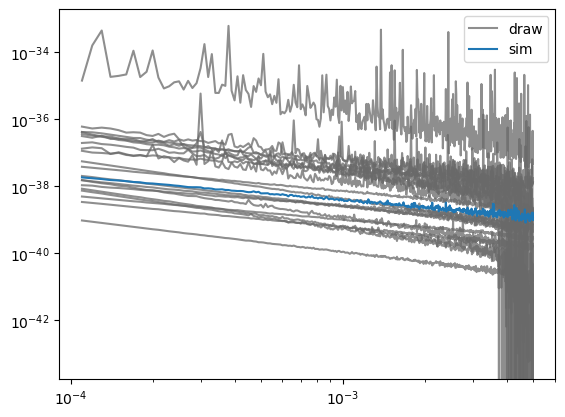

In [97]:
plt.figure()
for i in tqdm(range(20)):
    if i == 0:
        label='draw'
    else:
        label='__nolabel__'
    test_f, test_fg, _ = test_popmodel.run_model()
    plt.loglog(test_f, test_fg,label=label,c='dimgrey',alpha=0.75)
plt.loglog(test_f,data_fg,label='sim')
plt.legend()
plt.show()
    

Nice, even on CPU the optimizations have bought us a factor of $\sim2$. More, actually, given that we have moved from computing 20% of the binaries in a given bin to summing over all of them (due to fidelity issues in some cases). Draws are performing as expected.

Now let's check the likelihood.

In [98]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':data_N_res}
test_popmodel.construct_likelihood(datadict)

In [99]:
test_popmodel.Nsamp = 20
chain_out, fs, specs, Ns = test_popmodel.sample_likelihood(save_spec=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:32<00:00,  4.61s/it]


In [100]:
L_mask = [True if not np.isinf(L) else False for L in chain_out[-1,:] ]

In [101]:
L_mask

[True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True]

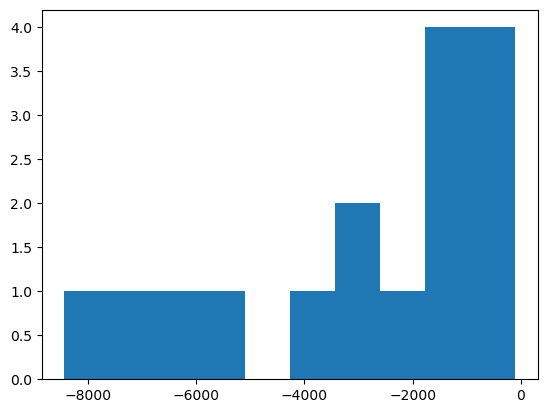

In [102]:
plt.figure()
plt.hist([L for L in chain_out[-1,:] if not np.isinf(L) ])
plt.show()

In [103]:
np.argmax(chain_out[-1,:])

10

In [104]:
chain_out[-1,:]

array([ -990.43461384, -3802.28519068, -8441.10658077,           -inf,
        -231.84881142,           -inf,  -517.24972585, -7461.44016898,
                 -inf, -6627.72995943,   -99.92708658, -1880.32731131,
       -2650.74794726,           -inf, -5480.17355913, -1460.37825295,
       -1387.01441429, -2702.61824335,  -911.65081293, -1087.48884164])

In [105]:
Ns

[1114,
 102,
 5127,
 9081,
 656,
 8702,
 1019,
 51,
 15788,
 68,
 989,
 1187,
 2105,
 6127,
 1126,
 676,
 416,
 3199,
 229,
 241]

In [106]:
Ns[np.argmax(chain_out[-1,:])]

989

In [116]:
np.array(Ns)[[not L for L in L_mask]]

array([ 9081,  8702, 15788,  6127])

In [122]:
[key for key in test_hprior.hyperprior_dict.keys()]

['m_mu', 'm_sigma', 'd_gamma_a', 'd_gamma_b', 'a_alpha']

In [124]:
chain_out[:-1,:][:,[not L for L in L_mask]].T

array([[0.6212455 , 0.17038061, 1.90726522, 3.07687682, 0.92089181],
       [0.51244945, 0.10452505, 3.18742625, 6.16335726, 1.18393986],
       [0.60060463, 0.44354172, 1.10134408, 7.18516071, 0.77745918],
       [0.61732269, 0.23661042, 4.67779974, 6.90764452, 1.176571  ]])

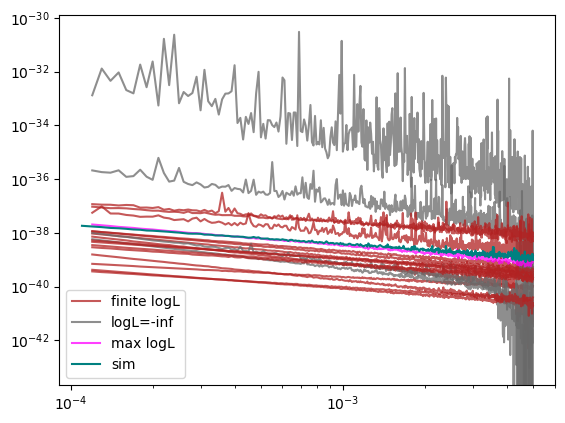

In [107]:
plt.figure()
finite_label_count = 0
inf_label_count = 0
for i in range(test_popmodel.Nsamp):
    if L_mask[i]:
        color='firebrick'
        if i==np.argmax(chain_out[-1,:]):
            color='magenta'
            label='max logL'
        else:
            if finite_label_count == 0:
                label='finite logL'
                finite_label_count +=1
            else:
                label='__nolabel__'
    else:
        color='dimgrey'
        if inf_label_count == 0:
            label='logL=-inf'
            inf_label_count +=1
        else:
            label='__nolabel__'
        
    plt.loglog(fs, specs[i],label=label,c=color,alpha=0.75)
plt.loglog(test_f,data_fg,label='sim',c='teal')
plt.legend()
plt.show()

Noting that there are extremal cases like the top curve where coarsegraining our frequency resolution is likely causing problems. These are cases with large numbers of high-amplitude binaries, and by reducing the frequency resolution we are probably not accounting for LISA's actual ability to resolve these high-amplitude systems from one another. That being said, this is ncessarily happening for such heavy-tailed populations that I'm skeptical that these are valid solutions in any case. 

We still need to deal with this down the road, though. For now I'm fine with it for the toy model case since we'll have to dispense with this approximation for the realistic global fit case anyway.

In any case, on to testing the sampling!

In [188]:
ndim = len(test_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [222]:
test_rng = np.random.default_rng(42)

In [223]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2),
                        1:st.invgamma(test_rng,5),
                        2:st.uniform(test_rng,loc=2.5,scale=3), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [224]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x7605d311d0a0>,
 'm_sigma': <distributions.invgamma at 0x7605d311e270>,
 'd_gamma_a': <distributions.uniform at 0x7605d314bc80>,
 'd_gamma_b': <distributions.uniform at 0x7605d3149850>,
 'a_alpha': <distributions.uniform at 0x7605d3075490>}

In [225]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [226]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict)

In [227]:
eryn_popmodel.construct_likelihood(datadict)

In [228]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [229]:
pool = Pool(nwalkers)

In [230]:
ensemble = EnsembleSampler(nwalkers,
                            ndim,
                            log_like_fn,
                            eryn_prior,
                            pool=pool)

In [231]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))

# check log_like, forcing the initialization to have finite log likelihood
log_like=np.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while np.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = np.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = np.asarray([
    eryn_prior.logpdf(coords[i])
for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.38s/it]

Log-likelihood:
 [ -132.89261501  -678.7826089   -693.76042575  -511.94399083
 -1308.08432482 -1767.36912287 -1595.86667512  -410.73492332
  -162.99509583  -196.35001415]

Log-prior:
 [1.51918435 1.43631849 1.56719774 1.5512845  1.51950672 1.26510184
 1.33803885 1.03263569 1.5718752  1.55968188]


In [232]:
nsteps = 100
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
pool.close()
pool.join()

  1%|█▉                                                                                                                                                                                          | 1/100 [00:11<19:17, 11.69s/it]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/moves/move.py:515: RuntimeWarning: invalid value encountered in multiply
  temp_change_log_like = new_log_likes * (accepted_temp) + old_log_likes * (
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [23:07<00:00, 13.87s/it]


In [233]:
pool.terminate()

In [209]:
# pool.terminate()

In [234]:
injdict = pop_theta
truths = np.array([injdict[key] for key in injdict.keys()]).flatten()

In [235]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

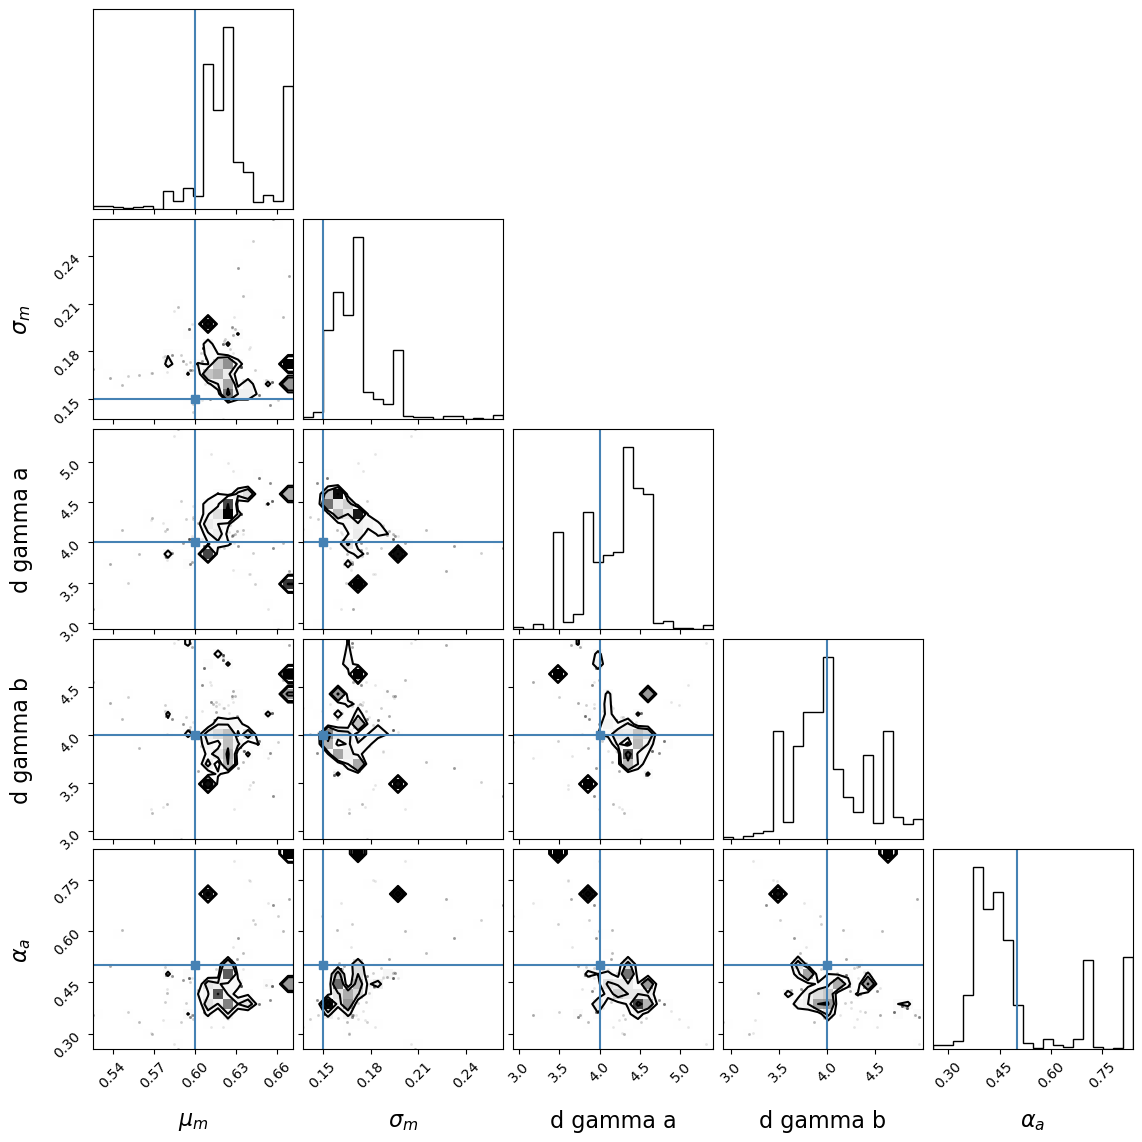

In [236]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

Okay, good. It runs, and produces something vaguely reasonable for such a short chain. End of notebook; next steps are to try out the GPU implementation!